In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import concurrent
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from concurrent.futures import ThreadPoolExecutor
from IPython.core.display import display, HTML

warnings.filterwarnings("ignore")

In [2]:
# load dataset
df = None

def read_csv(url):
    return pd.read_csv(url, dtype={
        "CRS_DEP_TIME": str,
        "DEP_TIME": str,
        "CRS_ARR_TIME": str,
        "MONTH": str,
        "DAY_OF_MONTH": str,
        "DAY_OF_WEEK": str,
    })

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    future_list = []

    for index in range(1, 13):
        future = executor.submit(read_csv, f"datasets/airline_arrival_delay/month{index}.csv")
        future_list.append(future)

    for future in future_list:
        try:
            result = future.result(timeout=20)
            if df is None:
                df = result
            else:
                df = df.append(result)
        except Exception as e:
            print("Cannot load", e)

In [3]:
old_columns = df.columns

# convert column names to Pascal case
for old_column in old_columns:
    new_column = "".join([segment.lower().capitalize() for segment in old_column.split("_")])
    df[new_column] = df[old_column]

df = df.drop(old_columns, axis=1)
df_bk = df.copy()                    

## All columns and their description

1. Year: ~~ 1987-2008 ---- Year doesn't tell any story.
2. Month: ~~ 1-12
3. DayofMonth: ~~ 1-31
4. DayOfWeek: ~~ 1 (Monday) - 7 (Sunday)
5. DepTime: ~~ actual departure time (local, hhmm)
6. CRSDepTime: ~~ scheduled departure time (local, hhmm)
7. ArrTime: ~~ actual arrival time (local, hhmm)
8. CRSArrTime: ~~ scheduled arrival time (local, hhmm)
9. UniqueCarrier: ~~ unique carrier code
10. FlightNum: ~~ flight number
11. TailNum: ~~ plane tail number
12. ActualElapsedTime: ~~ in minutes
13. CRSElapsedTime: ~~ in minutes ------ __have negative number__
14. AirTime: ~~ in minutes
15. ArrDelay: ~~ arrival delay, in minutes
16. DepDelay: ~~ departure delay, in minutes ------ __have negative number__
17. Origin: ~~ origin IATA airport code
18. Dest: ~~ destination IATA airport code
19. Distance: ~~ in miles
20. TaxiIn: ~~ taxi in time, in minutes
21. TaxiOut: ~~ taxi out time in minutes
22. Cancelled: ~~ was the flight cancelled?
23. CancellationCode: ~~ reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24. Diverted: ~~ 1 = yes, 0 = no
25. CarrierDelay: ~~ in minutes
26. WeatherDelay: ~~ in minutes
27. NASDelay: ~~ in minutes
28. SecurityDelay: ~~ in minutes
29. LateAircraftDelay: ~~ in minutes

---

__Taxi-in definition:__ Pre-enter the airport's operations (call gate agents to open the gate, ground crew to clear everything out of the way, ...)

_Description:_ Just a couple of minutes and you will finally be getting into the gate! While your pilots taxi in to your gate, everyone is getting ready for your arrival. Usually the pilots will give operations a call on the radio to make sure the gate agents and ground crew will be ready to meet your flight. The ground crew is clearing everything out of the way while your pilots are still being very safety-minded and being vigilant about other aircraft and obstacles in the way as they get closer to your gate.

---

__Taxi-out definition:__ Get the things ready to take off the flights

_Description:_ The Taxi Out phase includes a lot of things happening in the cockpit and the cabin. The flight attendants are making sure the cabin is ready for takeoff and conducting the emergency brief. The pilots are starting the engines and requesting permission to taxi. While it seems that this is a relatively easy phase of your flight, its' anything but, especially when it is a very busy airport, a lot of aircraft taxiing around, maybe reduced visibility. That is why many airlines have gotten rid of the "Taxi Checklist" because all of the pilots' attention should be on taxiing to the runway, the First Officer backing up the Captain.

---

__Numerical features:__ DepDelay, TaxiIn, CrsElapsedTime, Distance, Diverted

__Categorical features:__ Month, DayOfMonth, DayOfWeek, OpUniqueCarrier, TailNum, Origin, Dest, CrsDepTime, DepTime, CrsArrTime

In [4]:
# define label for dataset
df["IsLate"] = df["ArrDelay"].apply(lambda x: x > 30)

# we first ignore the canceled flights because we only predict the flights are late or not
df = df[df["Cancelled"] == False]
# because we only classify whether the flight is late or not, so we have to drop the other delay columns
df = df.drop(["Cancelled",
              "CancellationCode",
              # drop columns which don't have value in departure time
              "TaxiOut",
              "ActualElapsedTime",
              "AirTime",
              "ArrTime",
              "ArrDelay",
              # flights feature doesn't seem to have any meaning (always equal 1)
              "Flights",
              # not in the feature list
              "OpCarrierFlNum",
              # because we only gather data in one year, "year" feature doesn't seem to have any effect
              "Year"], axis=1)

## Exploratory Data Analysis

In [5]:
# after filtering unnecessary columns, we now have only 21 features and 1 label
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4407320 entries, 0 to 371356
Data columns (total 16 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Month            object 
 1   DayOfMonth       object 
 2   DayOfWeek        object 
 3   OpUniqueCarrier  object 
 4   TailNum          object 
 5   Origin           object 
 6   Dest             object 
 7   CrsDepTime       object 
 8   DepTime          object 
 9   DepDelay         float64
 10  TaxiIn           float64
 11  CrsArrTime       object 
 12  Diverted         float64
 13  CrsElapsedTime   float64
 14  Distance         float64
 15  IsLate           bool   
dtypes: bool(1), float64(5), object(10)
memory usage: 542.2+ MB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DepDelay,4407320.0,2.051833,36.128978,-128.0,-7.0,-4.0,-1.0,3890.0
TaxiIn,4406514.0,6.814271,5.036725,1.0,4.0,5.0,8.0,280.0
Diverted,4407320.0,0.001757,0.041881,0.0,0.0,0.0,0.0,1.0
CrsElapsedTime,4407320.0,138.112784,68.221151,-77.0,89.0,122.0,168.0,700.0
Distance,4407320.0,781.713239,557.401631,29.0,370.0,640.0,1018.0,5095.0


__DepDelay:__ Negative numbers means taking off before scheduled time

__CrsElapsedTime:__ Negative numbers means flying back in time zone (bay ngược múi giờ)

In [7]:
df.describe(include="O")

,Month,DayOfMonth,DayOfWeek,OpUniqueCarrier,TailNum,Origin,Dest,CrsDepTime,DepTime,CrsArrTime
count,4407320,4407320,4407320,4407320,4407318,4407320,4407320,4407320,4407320,4407320
unique,12,31,7,17,5820,367,367,1321,1440,1401
top,1,13,4,WN,N494HA,ATL,ATL,0700,0655,1900
freq,600418,152929,662047,883434,1733,243342,243298,87427,12237,15420


In [8]:
df.head(5).T

,0,1,2,3,4
Month,1,1,1,1,1
DayOfMonth,1,1,1,1,1
DayOfWeek,3,3,3,3,3
OpUniqueCarrier,WN,WN,WN,WN,WN
TailNum,N951WN,N467WN,N7885A,N551WN,N968WN
Origin,ONT,ONT,ONT,ONT,ONT
Dest,SFO,SFO,SJC,SJC,SJC
CrsDepTime,1810,1150,2020,1340,0915
DepTime,1851,1146,2016,1350,0916
DepDelay,41.0,-4.0,-4.0,10.0,1.0


In [9]:
print(f"Total rows: {len(df)}")

Total rows: 4407320


### Check missing values

In [10]:
# list all columns with their total missing values
nan_summary = df.isnull().sum()
nan_summary

Month                0
DayOfMonth           0
DayOfWeek            0
OpUniqueCarrier      0
TailNum              2
Origin               0
Dest                 0
CrsDepTime           0
DepTime              0
DepDelay             0
TaxiIn             806
CrsArrTime           0
Diverted             0
CrsElapsedTime       0
Distance             0
IsLate               0
dtype: int64

In [11]:
# the missing value is not really significant => drop all missing vlaue
df = df.dropna()

### Heatmap visualization

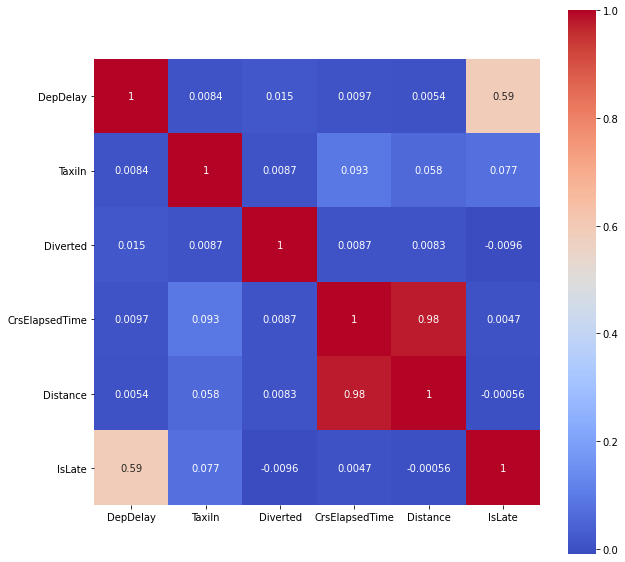

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, square=True, cmap="coolwarm", ax=ax);

# the scheduled time & actual time is strictly correlated -> should get the difference
# airtime & distance are also correlated with actual & schedule elapsed time

### Visualization numerical data based on IsLate label

<Figure size 720x504 with 0 Axes>

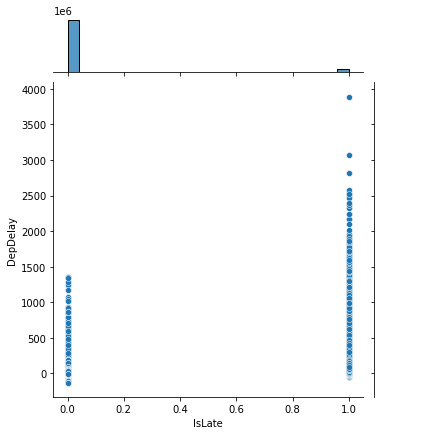

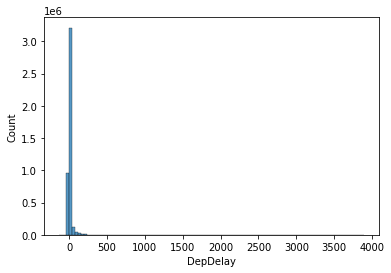

<Figure size 720x504 with 0 Axes>

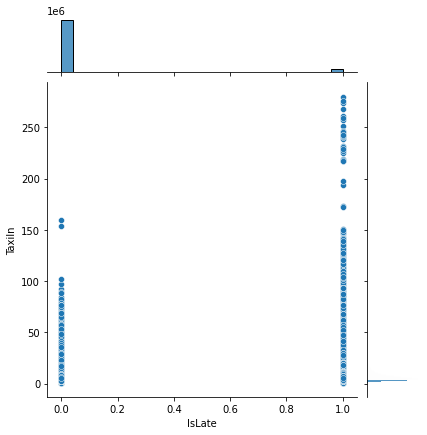

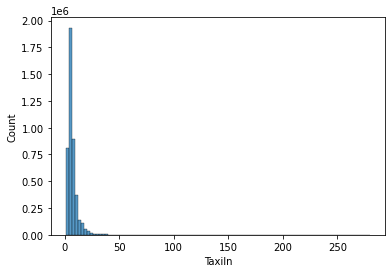

<Figure size 720x504 with 0 Axes>

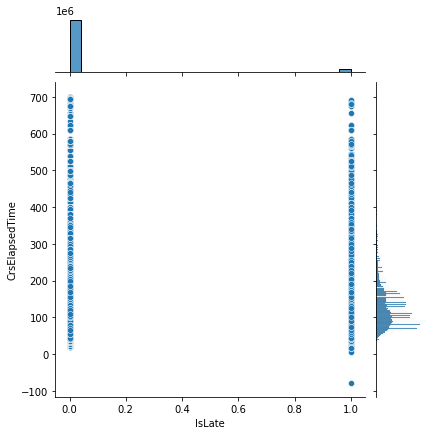

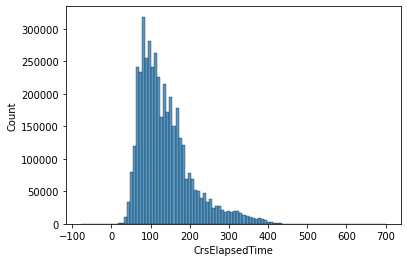

<Figure size 720x504 with 0 Axes>

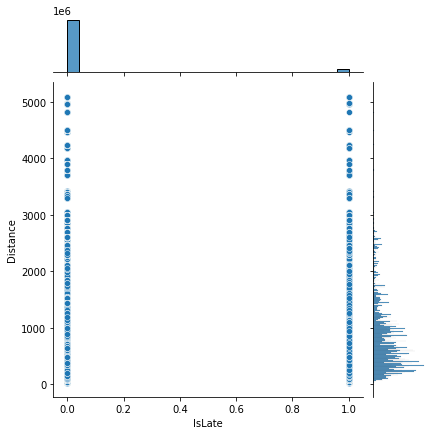

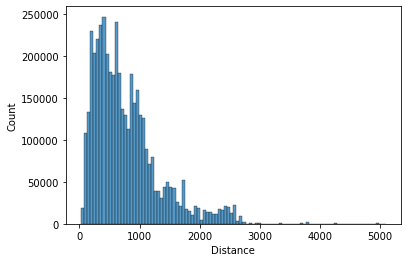

In [13]:
numerical_features = ["DepDelay", "TaxiIn", "CrsElapsedTime", "Distance"]

for column in numerical_features:
    plt.figure(figsize=(10, 7))
    display(HTML(f"<h4>{column}</h4>"))
    
    sns.jointplot(data=df, x="IsLate", y=column);
    plt.show()
    
    sns.histplot(df[column], bins=100);
    plt.show()

# DepDelay: when the flights are late, we can see that the DepDelay feature ranges significantly from ~0 -> 2500
# Via data population, I can see that the features DepDelay, TaxiIn affect the lateness directly
# Significantly, distance doesn't show any relation with IsLate

### Visualization categorical data based on IsLate label

In [14]:
def split_hour(date):
    return date[:2]


def split_min(date):
    return date[2:4]


def add_prefix_to_date(day):
    if len(day) == 1:
        return f"0{day}"
    
    return day


df["CrsDepTime_Hour"] = df["CrsDepTime"].apply(split_hour)
df["DepTime_Hour"] = df["DepTime"].apply(split_hour)
df["CrsArrTime_Hour"] = df["CrsArrTime"].apply(split_hour)

df["Month"] = df["Month"].apply(add_prefix_to_date)
df["DayOfMonth"] = df["DayOfMonth"].apply(add_prefix_to_date)

df = df.drop(["DepTime", "CrsDepTime", "CrsArrTime"], axis=1)

In [15]:
def calculate_categorical_percentage(df, column):
    visualize = df.groupby(column)["IsLate"].value_counts().to_frame()
    visualize["TotalFlights"] = df.groupby(column)["IsLate"].value_counts().values
    visualize = visualize.drop(["IsLate"], axis=1).reset_index()
    
    column_values = visualize[visualize["IsLate"] == True][column].unique()
    total_flights = visualize[visualize[column].isin(column_values)].groupby(column)["TotalFlights"].sum()
    is_late = visualize[(visualize["IsLate"] == True) & (visualize[column].isin(column_values))]["TotalFlights"]
    is_not_late = visualize[(visualize["IsLate"] == False) & (visualize[column].isin(column_values))]["TotalFlights"]
    
    is_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_late)]
    is_not_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_not_late)]
    
    return visualize, column_values, is_late_percentage, is_not_late_percentage

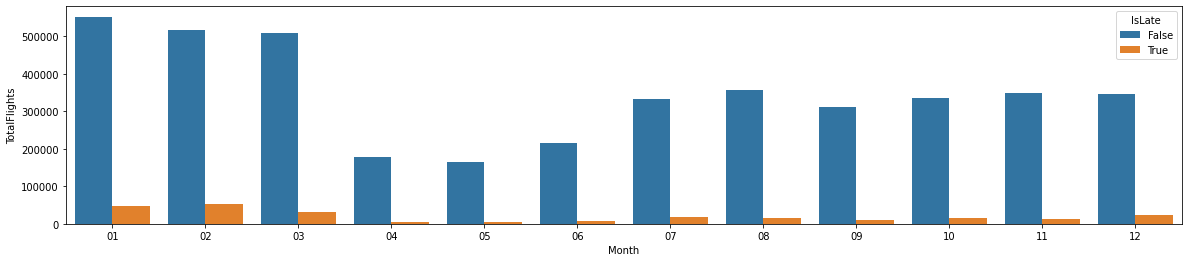

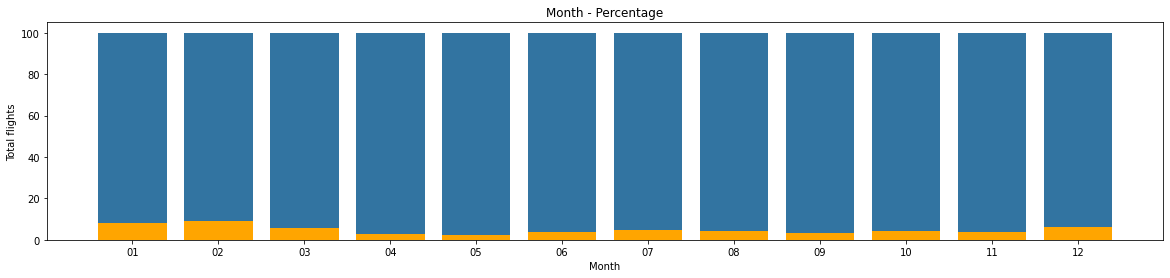

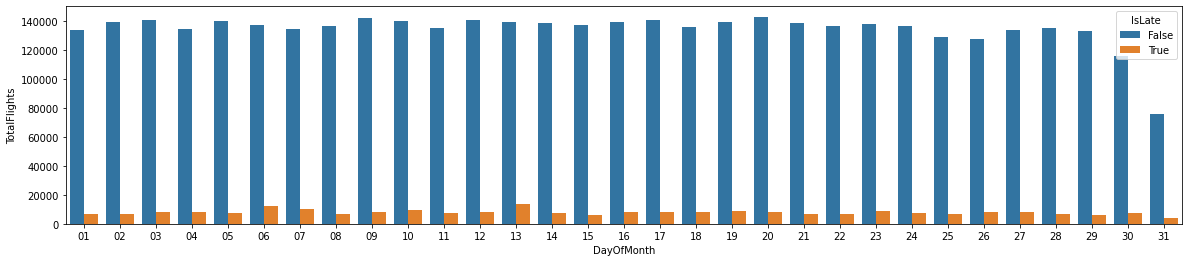

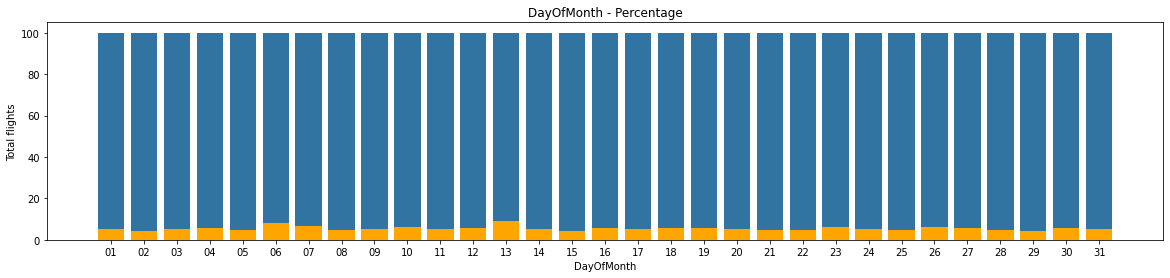

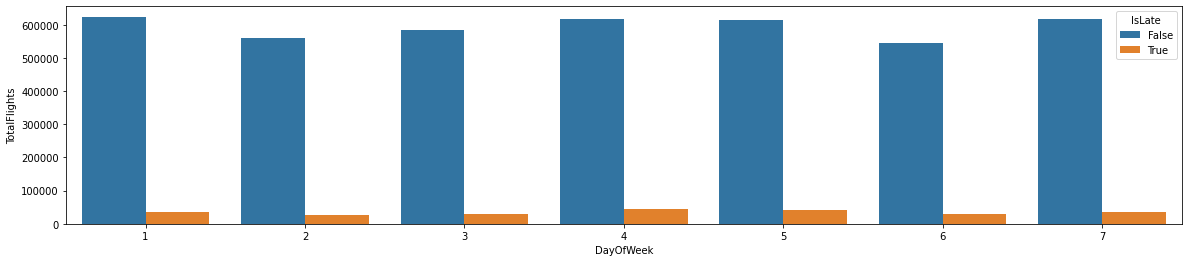

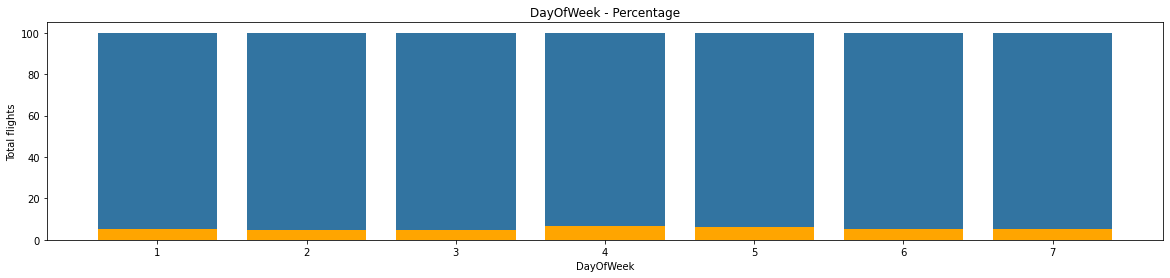

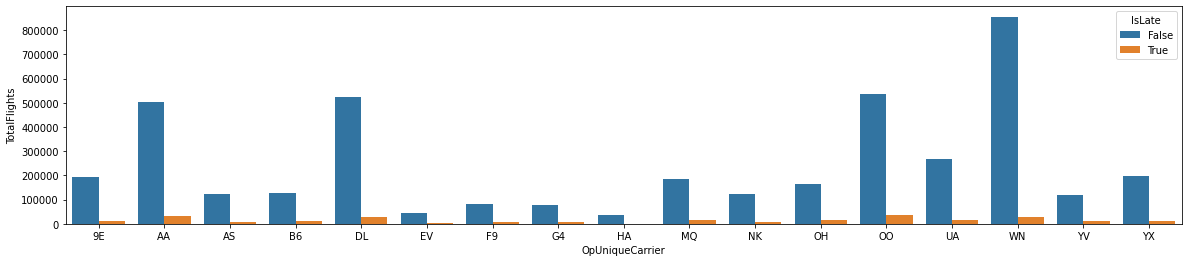

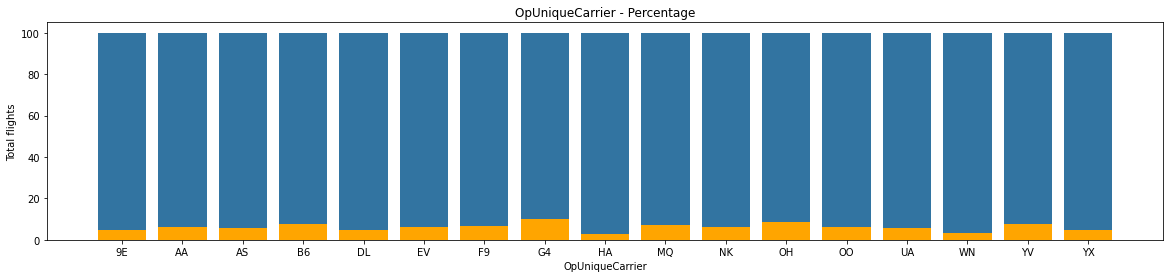

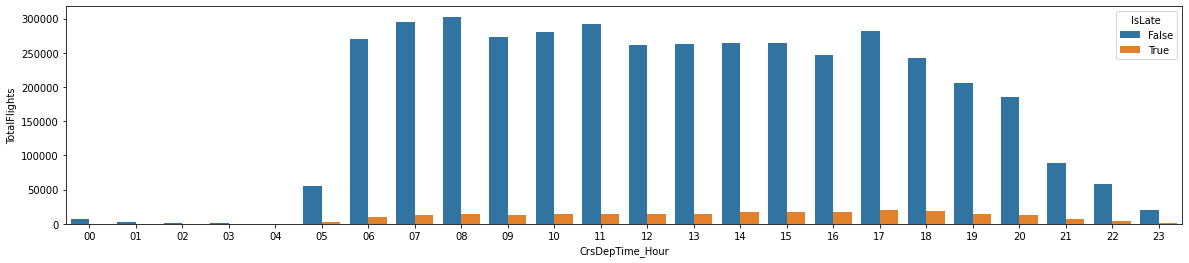

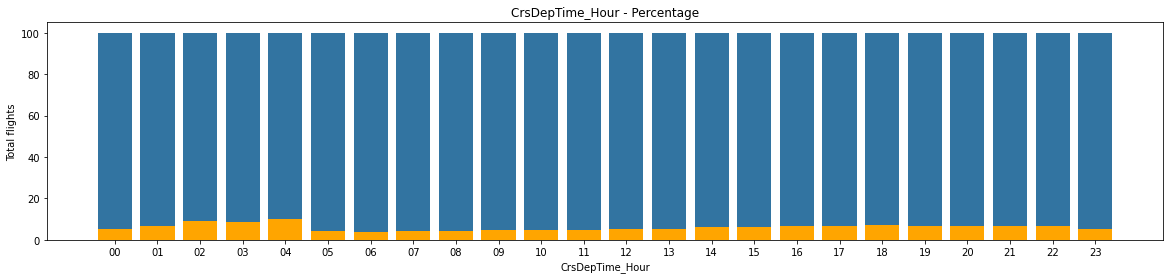

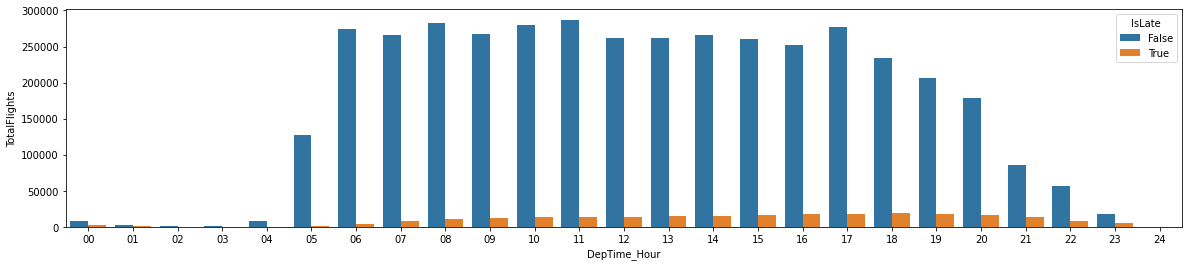

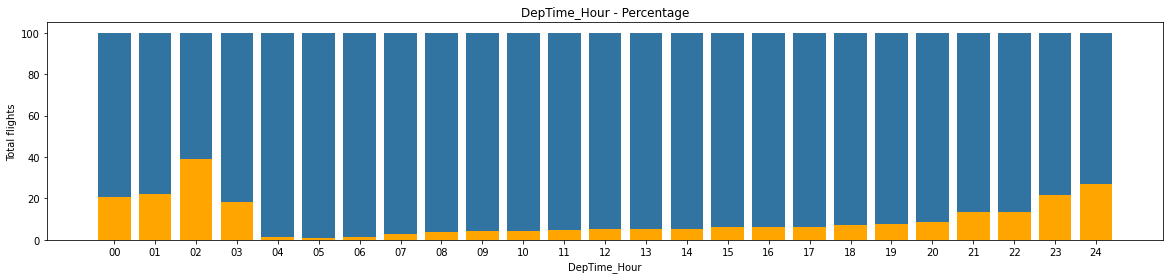

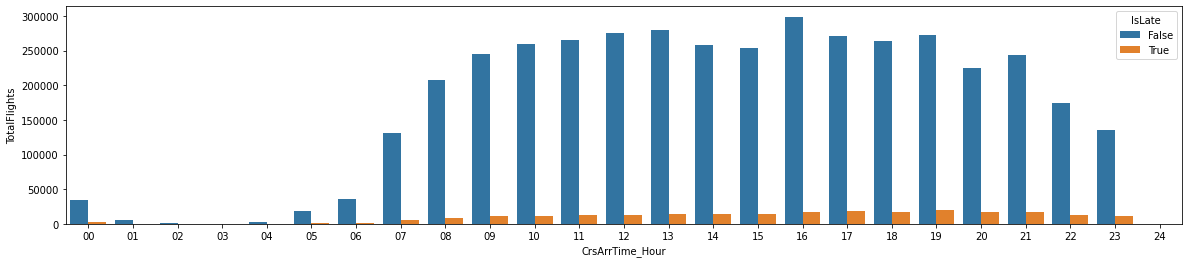

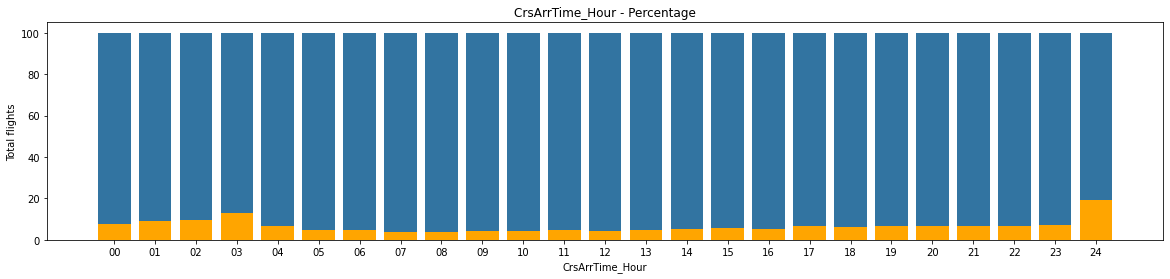

In [16]:
for column in ["Month", "DayOfMonth", "DayOfWeek", "OpUniqueCarrier", "CrsDepTime_Hour", "DepTime_Hour", "CrsArrTime_Hour"]:
    visualize, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column)
    
    display(HTML(f"<h4>{column}</h4>"))
    
    plt.figure(figsize=(20, 4))
    sns.barplot(x=column, hue="IsLate", y="TotalFlights", data=visualize);
    plt.show()

    # show IsLate percentage
    plt.figure(figsize=(20, 4))
    plt.bar(column_values, is_late_percentage, color="orange")
    plt.bar(column_values, is_not_late_percentage, bottom=is_late_percentage, color="#3274a1")
    plt.xlabel(column)
    plt.ylabel("Total flights")
    plt.title(f"{column} - Percentage")
    plt.show()

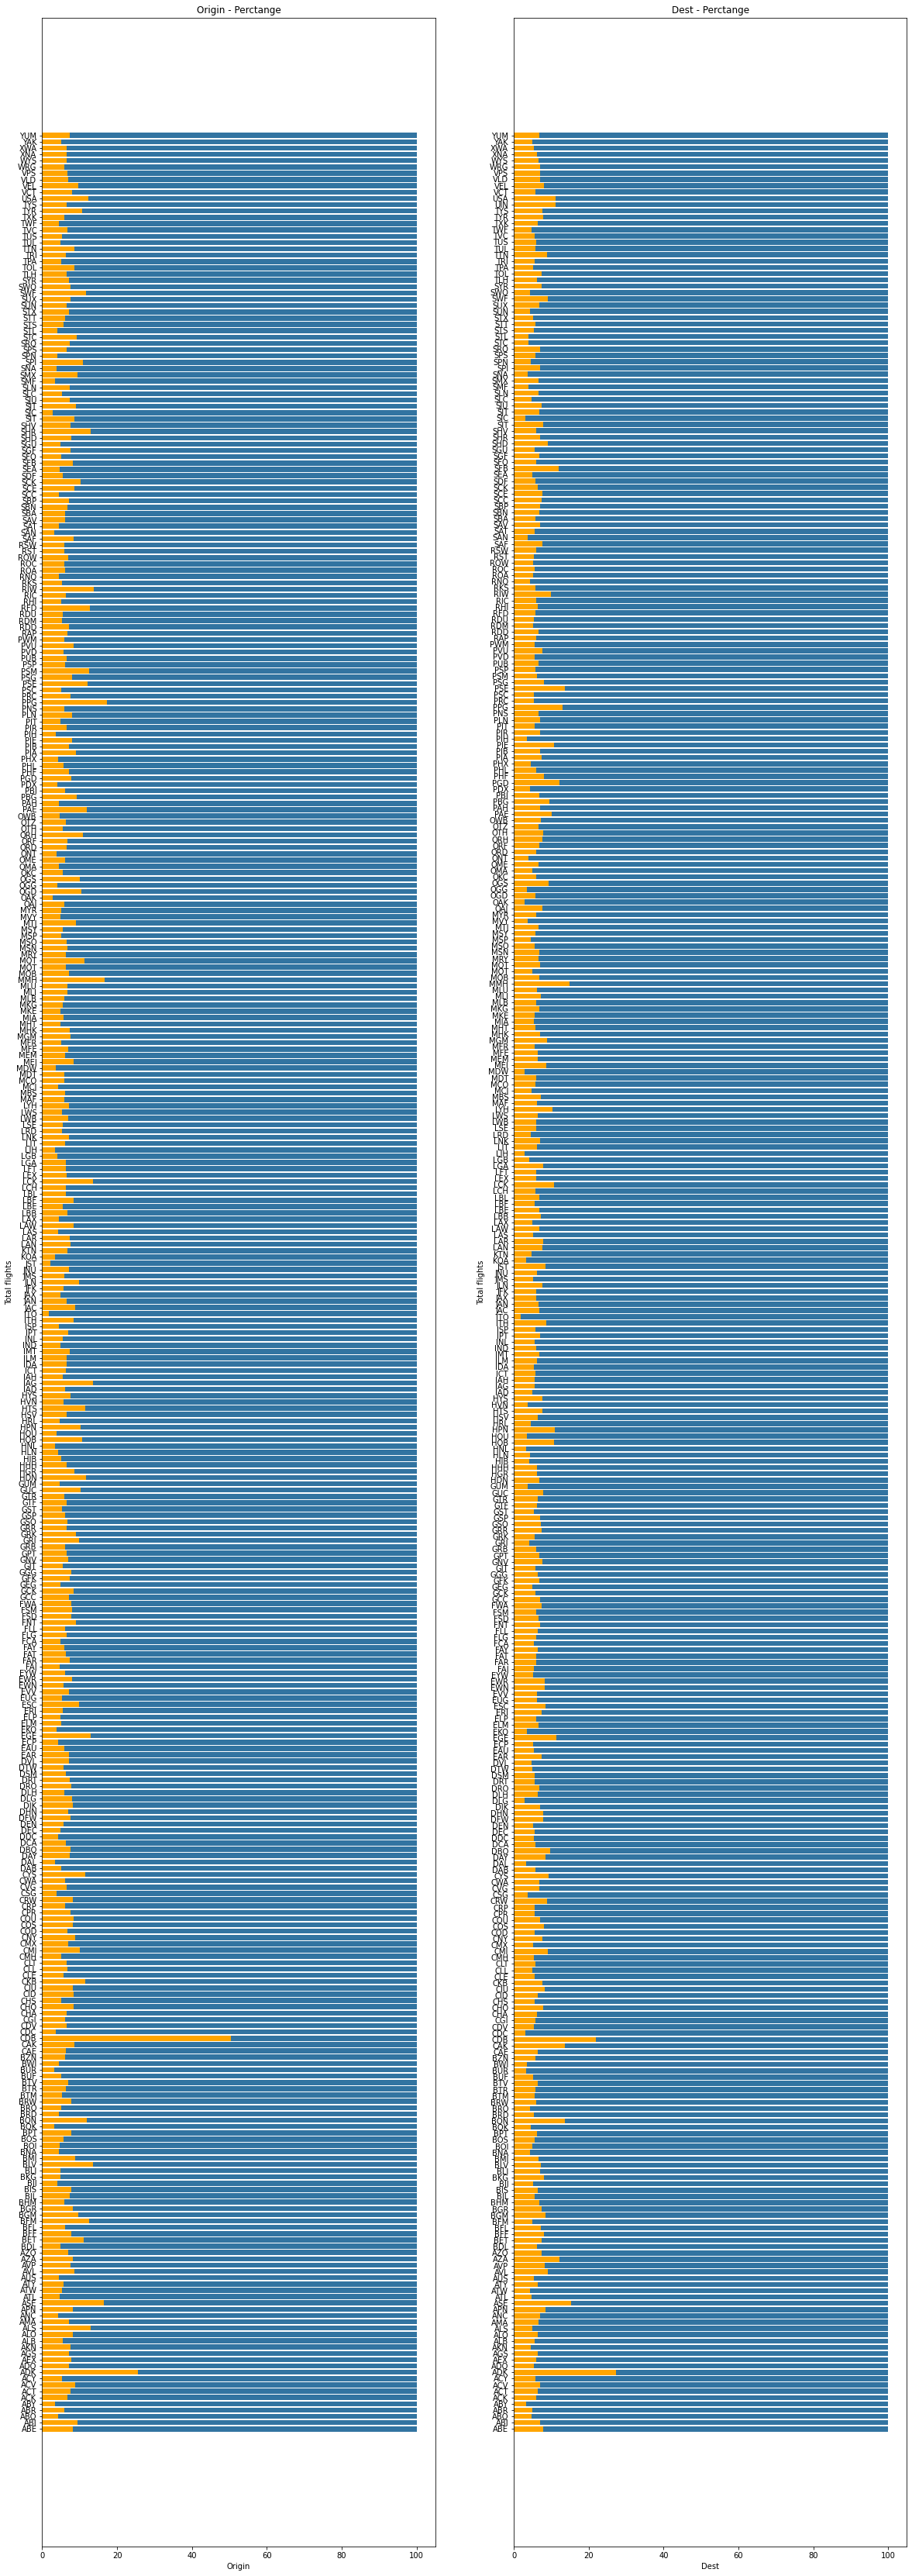

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 60))

column = "Origin"
_, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column)
ax[0].barh(column_values, is_late_percentage, color="orange")
ax[0].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
ax[0].set_xlabel(column)
ax[0].set_ylabel("Total flights")
ax[0].set_title(f"{column} - Perctange")

column = "Dest"
_, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column)
ax[1].barh(column_values, is_late_percentage, color="orange")
ax[1].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
ax[1].set_xlabel(column)
ax[1].set_ylabel("Total flights")
ax[1].set_title(f"{column} - Perctange")

plt.show()

<!--  "Origin", "Dest",  -->
According to the data, the late percentage is higher in the winter season (by month) and in the night time. The DayOfWeek doesn't seem to have any impact on the lateness. Furthermore, DayOfMonth also doesn't show a clear effect on the lateness.

The most significant feature here is OpUniqueCarier, the late flights varies depending on this feature, because obviously there are some carriers most of the times depart in incorrected timing.

Besides, origin and dest also contribute to the lateness. Because there are bad and good conditioning airports, large and small area, easily for flights to depart and land, ...

In [18]:
# show 31 days in every month to check when the demands increase
# show the lateness also

### Filter noise & Feature engineering

In [19]:
from scipy import stats

# due to having too manu unique values, we drop Origin and Dest
df = df.drop(["TailNum", "Origin", "Dest", "DayOfMonth", "DayOfWeek", "CrsDepTime_Hour"], axis=1)

# Q1,Q3 = np.percentile(sorted(df['Price']),[25,75])
# IQR = Q3 - Q1
# upperlim = Q3 + 1.5*IQR
# lowerlim = max(Q1 - 1.5*IQR,0)

# calculate z-score to filter noise
for feature in numerical_features:
    z_scores = np.abs(stats.zscore(df[feature]))
    df = df[z_scores <= 3]

In [21]:
dummy_columns = ["OpUniqueCarrier"]

for column in dummy_columns:
    df = df.join(pd.get_dummies(df[column], column, drop_first=True))
    
df = df.drop(dummy_columns, axis=1)

In [22]:
# feature engineering
# I see the abnormal from these hours and months, so I decided to create the new features for them
df["IsDepTimeNight"] = df["DepTime_Hour"].isin(["21", "22", "23", "24", "01", "02", "03"])
df["IsCrsArrTimeLateNight"] = df["CrsArrTime_Hour"].isin(["24", "01", "02", "03"])
df["IsRainySeason"] = df["Month"].isin(["12", "01", "02", "03"])

df = df.drop(["DepTime_Hour", "CrsArrTime_Hour", "Month"], axis=1)

In [25]:
df.head(5)

,DepDelay,TaxiIn,Diverted,CrsElapsedTime,Distance,IsLate,OpUniqueCarrier_AA,OpUniqueCarrier_AS,OpUniqueCarrier_B6,OpUniqueCarrier_DL,...,OpUniqueCarrier_NK,OpUniqueCarrier_OH,OpUniqueCarrier_OO,OpUniqueCarrier_UA,OpUniqueCarrier_WN,OpUniqueCarrier_YV,OpUniqueCarrier_YX,IsDepTimeNight,IsCrsArrTimeLateNight,IsRainySeason
0,41.0,4.0,0.0,95.0,363.0,True,0,0,0,0,...,0,0,0,0,1,0,0,False,False,True
0,41.0,4.0,0.0,95.0,363.0,True,0,0,0,0,...,0,0,0,0,0,0,0,False,False,True
0,41.0,4.0,0.0,95.0,363.0,True,1,0,0,0,...,0,0,0,0,0,0,0,False,False,True
0,41.0,4.0,0.0,95.0,363.0,True,0,0,0,0,...,0,1,0,0,0,0,0,False,False,True
0,41.0,4.0,0.0,95.0,363.0,True,0,0,0,0,...,0,0,0,0,1,0,0,False,False,True


In [30]:
df.groupby(["Diverted"])["IsLate"].value_counts()

Diverted  IsLate
0.0       False     34483590
          True       1411283
1.0       False        53583
Name: IsLate, dtype: int64

In [31]:
from sklearn.model_selection import train_test_split

In [34]:
# month -> RainySeason, DepTime_Hour -> IsDepTimeNight (21 -> 03), CrsArrTime_Hour -> IsCrsArrTimeLateNight (21 -> 03), keep OpUniqueCarrier
# drop DayOfMonth, DayOfWeek, CrsDepTime_Hour

X = df.drop(["IsLate"], axis=1)
y = df["IsLate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# because the below features don't illustrate the bell shape --> use min_max_scaling
min_max_scaling_columns = ["DepDelay", "TaxiIn", "CrsElapsedTime", "Distance"]

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train[min_max_scaling_columns])

X_train[min_max_scaling_columns] = min_max_scaler.transform(X_train[min_max_scaling_columns])
X_test[min_max_scaling_columns] = min_max_scaler.transform(X_test[min_max_scaling_columns])

### Train models

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [37]:
model = LogisticRegression()
model.fit(X_train, y_train);

In [53]:
test_score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test).max(axis=1)

test_score

0.9844646457138521

In [52]:
y_pred_prob

array([[9.96595025e-01, 3.40497453e-03],
       [9.95934415e-01, 4.06558543e-03],
       [9.91717259e-01, 8.28274076e-03],
       ...,
       [9.93846199e-01, 6.15380106e-03],
       [9.99325202e-01, 6.74797616e-04],
       [9.96569237e-01, 3.43076347e-03]])

In [49]:
print(classification_report(y_test, y_pred, target_names=["class 0", "class 1"]))

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99   8634061
     class 1       0.88      0.70      0.78    353053

    accuracy                           0.98   8987114
   macro avg       0.94      0.85      0.89   8987114
weighted avg       0.98      0.98      0.98   8987114



In [46]:
importances = pd.DataFrame({"Column": X.columns, "Amount": model.coef_[0] }) 
importances.sort_values("Amount", ascending=False)

,Column,Amount
0,DepDelay,24.923115
4,Distance,3.069744
1,TaxiIn,2.167534
23,IsRainySeason,0.190934
11,OpUniqueCarrier_G4,0.103216
7,OpUniqueCarrier_B6,0.084063
9,OpUniqueCarrier_EV,0.079918
13,OpUniqueCarrier_MQ,0.059856
19,OpUniqueCarrier_YV,0.047730
20,OpUniqueCarrier_YX,0.033685


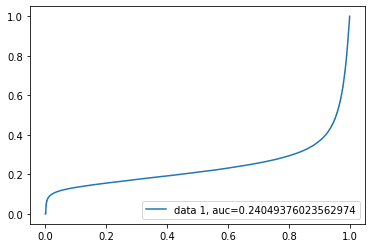

In [72]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [71]:
y_pred_prob = y_pred_prob.max(axis=1)

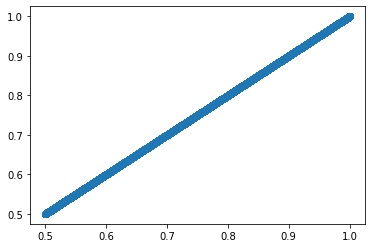

In [64]:
plt.scatter(y_pred_prob.max(axis=1), y_pred_prob.max(axis=1))